In [45]:
import pandas as pd
import numpy as np

# ========= CONFIG =========
FILE_NAME = "employee_attrition.csv"  # change only this
TARGET_COL = "attrition"               # change only this
# ==========================

# Load data
df = pd.read_csv(FILE_NAME)

# Separate target
y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

# Handle missing values
for col in X.columns:
    if X[col].dtype == "object":
        X[col].fillna(X[col].mode()[0], inplace=True)
    else:
        X[col].fillna(X[col].median(), inplace=True)

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

print("Final Shape:", X.shape)
print("Target Distribution:\n", y.value_counts())


Final Shape: (1200, 7)
Target Distribution:
 attrition
1    919
0    281
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_10216\776153658.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_10216\776153658.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
)


In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.34      0.29      0.31        62
           1       0.76      0.80      0.78       178

    accuracy                           0.67       240
   macro avg       0.55      0.55      0.55       240
weighted avg       0.65      0.67      0.66       240

ROC-AUC: 0.5468466835810075


In [48]:
from sklearn.model_selection import GridSearchCV




In [49]:
param_grid = {
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}










In [50]:
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1"
)



In [51]:
grid.fit(X_train, y_train)



,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [52]:
best_dt = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1: 0.8523379172204066


In [53]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_dt.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(10))


              Feature  Importance
6      overtime_hours    0.353753
5   work_life_balance    0.164331
3    job_satisfaction    0.148605
1      monthly_salary    0.123242
4  performance_rating    0.092867
0                 age    0.070468
2    years_at_company    0.046733


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_ann(neurons=64, dropout=0.3, lr=0.001):
    model = keras.Sequential([
        layers.Dense(
            neurons,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.001),
            input_shape=(X_train_scaled.shape[1],)
        ),
        layers.Dropout(dropout),
        layers.Dense(neurons // 2, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [56]:
model = build_ann()

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)


Epoch 1/100


c:\Users\User\Downloads\007\.conda\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6576 - loss: 0.6540 - val_accuracy: 0.7604 - val_loss: 0.6032
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7695 - loss: 0.5769 - val_accuracy: 0.7604 - val_loss: 0.5554
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7721 - loss: 0.5298 - val_accuracy: 0.7604 - val_loss: 0.5326
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7773 - loss: 0.5078 - val_accuracy: 0.7552 - val_loss: 0.5221
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7630 - loss: 0.5044 - val_accuracy: 0.7656 - val_loss: 0.5158
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7734 - loss: 0.4955 - val_accuracy: 0.7708 - val_loss: 0.5131
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7786 - loss: 0.4986 - val_accuracy: 0.7500 - val_loss: 0.5110
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7891 - loss: 0.4920 - val_accuracy: 0.7604 - val_loss: 0.

In [57]:
loss, acc = model.evaluate(X_test_scaled, y_test)
print("ANN Test Accuracy:", acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7583 - loss: 0.5269  
ANN Test Accuracy: 0.7583333253860474


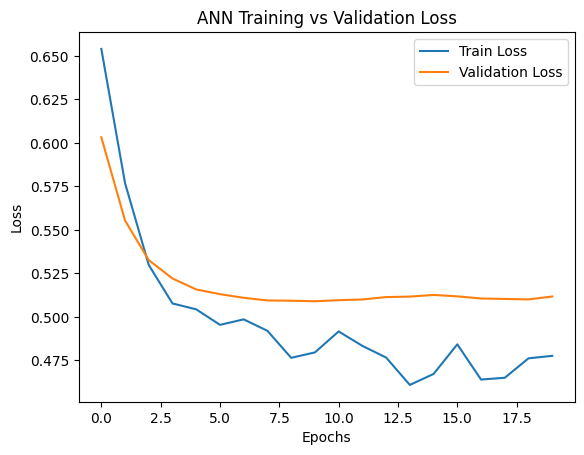

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training vs Validation Loss")
plt.show()
